In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.680049  0.549073 -0.133982 -0.858746 -0.057113  0.782577  0.019024   
  1  -0.103497 -0.509110  0.034665  0.491319  0.384064 -0.226704 -0.969930   
  2  -0.072871  0.162154  0.617178  0.107270  0.449036  0.779954  0.454017   
  3  -0.420565  0.412799 -0.611759  0.301984  0.756474  0.133544 -0.886513   
  4   0.610485 -0.413275 -0.468094  0.400655 -0.104498  1.007718  0.017245   
  5  -0.631119 -0.110448 -0.715125  0.095129  0.020800  1.865347  0.113148   
  6   0.523747  1.640721  0.250028 -0.276759  0.171719 -0.028661 -0.826897   
  7  -0.130575 -0.169954  0.325197  1.230521 -0.116573  0.297420 -0.297601   
  8   0.063006 -0.288440  0.039598  0.267326 -0.343302  0.646838  0.675910   
  9   0.109340 -0.307243  0.368898 -0.005583 -0.649266  0.105684  0.086777   
  10  0.258801 -0.033208 -0.595020  0.776381  0.350627 -0.052189 -0.373575   
  11 -0.302679 -0.108991  0.059955 -0.126089 -1.238948 -0.145211 -0.339195   
  12  0.429111 -0.245299 -0.342178  0.119471 -0.543379 -0.321680 -0.066635   
  13 -0.198574  0.448065  1.087451  0.630698 -0.296001 -0.666413 -1.093574   
  14 -0.326198 -1.103068  0.734715  0.426021 -0.298725 -0.151403 -0.702290   
  15 -0.946115 -0.894163 -0.092469  0.770958 -0.209138 -0.350368 -1.079294   
  16 -0.375823  0.473262 -0.034297  1.396104  0.383991  0.089594 -0.794280   
  17  0.329589 -0.468029 -0.292667 -0.522431 -0.463926 -0.458973  0.323185   
  18  0.277114  0.295502  0.171810 -0.384195 -0.341832  1.126850 -0.240540   
  19 -0.278023  0.810822 -0.178160 -1.132871 -0.977774 -0.836981 -0.041328   
  20  0.586209  0.337353 -0.225413  0.712750 -0.169337  0.457760 -0.341368   
  21 -1.409642  0.403749 -0.024683  0.042204 -0.708234 -0.668901 -1.233184   
  22  0.078077  0.028022  0.578913 -0.746597 -1.111076  0.325130  0.720326   
  23  0.094008 -0.281523 -1.182112  0.050478 -0.106934  0.418297  0.077458   
  24 -0.536361  0.312411  0.248610  0.555668 -0.471995 -0.361087 -0.860818   
1 0   0.399812  0.497916  0.728731 -0.804734 -0.835948 -0.665164  0.815814   
  1   0.241063 -0.737248  0.412082  0.456921 -0.123765 -1.142606 -0.295181   
  2  -0.438158 -1.188938 -0.286431  0.429684 -1.285644  0.131107  0.088693   
  3  -0.162413 -0.086198 -0.092737  0.260737 -1.121503  0.499957 -0.138893   
  4  -0.117808 -0.340880 -0.686139 -0.054324  0.031566 -0.191080  0.604449   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.048557 -0.153730  1.384649  ... -0.530872 -0.226189 -0.197096   
  1  -0.652555  0.007980 -0.043001  ...  0.682669  0.688059  0.201450   
  2  -0.114670  0.031165 -1.017348  ...  0.358299  0.453263 -0.696496   
  3  -0.264132  0.886443  0.975922  ...  0.177135  1.322784  0.288500   
  4  -0.431193  0.675444  1.094677  ...  0.657253  0.020805 -0.023788   
  5  -1.037578 -1.229091 -0.060470  ...  1.248291  0.460213 -0.217252   
  6   0.056953 -0.170563  0.043970  ... -0.244642 -0.304300  0.512604   
  7   0.185003 -0.362977  0.339673  ...  0.170549 -0.452061 -0.165593   
  8  -0.078615 -0.399895 -0.391323  ...  0.038363  1.300432  0.153673   
  9  -0.449285 -0.750925  0.377950  ... -0.357505 -0.113617  0.264042   
  10 -0.287238 -0.790871  0.129450  ...  0.899611  0.175766  0.475310   
  11 -0.285895 -0.243674  0.617755  ... -0.615442  0.207919  0.873258   
  12  0.442032 -0.499149  0.352105  ...  0.596141  0.555884 -0.546507   
  13 -0.311606 -0.290889  0.242867  ...  0.811335  0.940108  0.176033   
  14  0.227089 -0.405343  0.108236  ...  0.408488 -0.088604  0.539951   
  15 -0.554263 -0.294297  0.021042  ...  0.500114  1.300414  0.760192   
  16 -0.484792 -0.813171  0.145767  ...  0.255088  0.196664 -0.959981   
  17  0.157207 -0.595421 -0.249094  ...  0.244041  0.001039  0.153680   
  18  0.532092 -0.218294  0.219923  ... -0.889207 -0.034688  0.777844   
  19  0.864496  0.701094  0.266703  ...  0.255021  0.798155  0.477264   
  20  0.772867  0.103194  0.037228  ...  0.586519  0.404472 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.056789  0.040351  26.190201  3.436349e-151  0.977704  1.135875


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



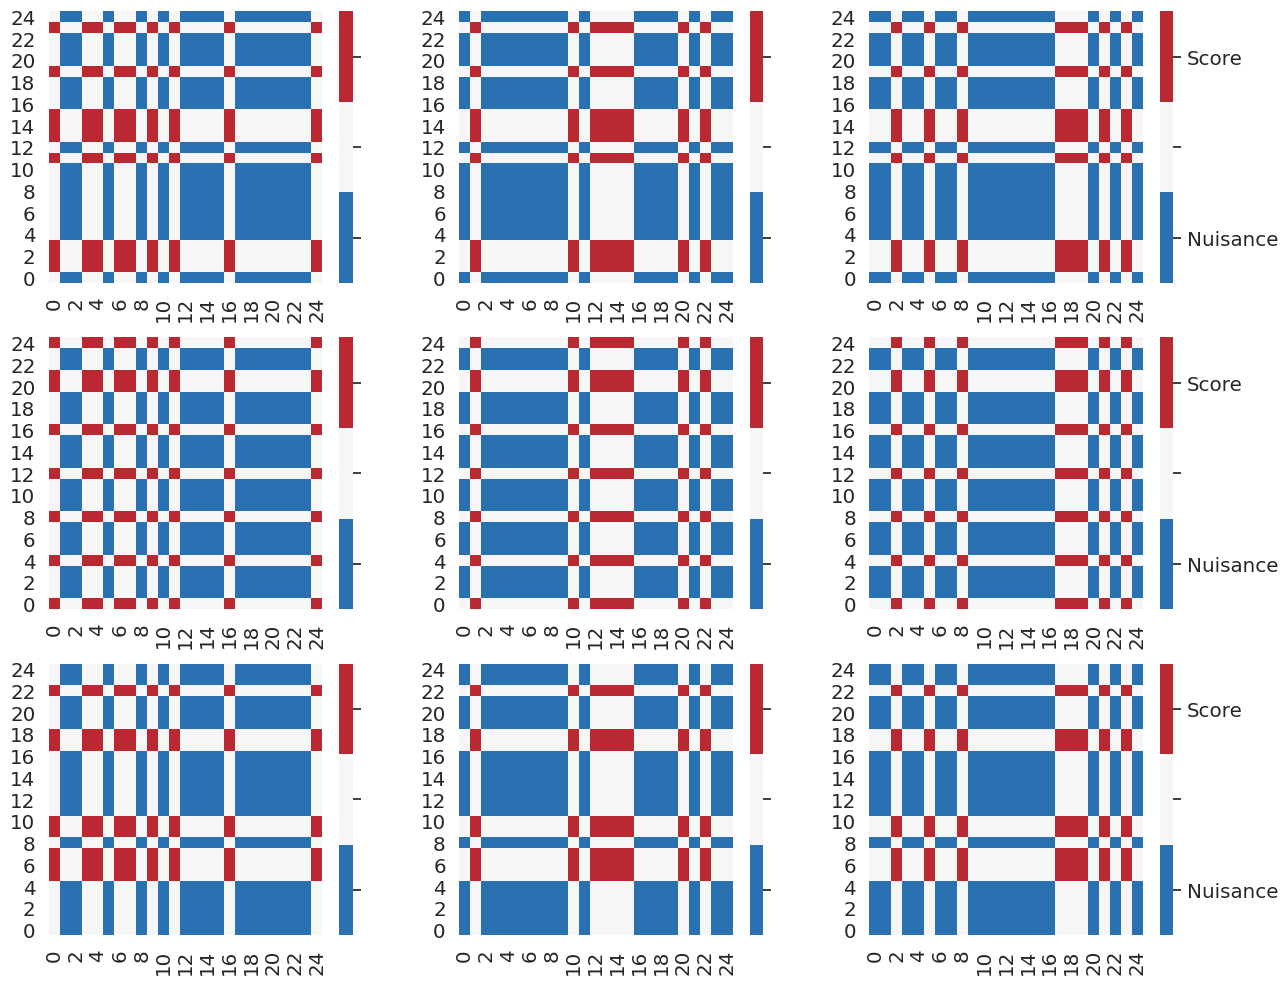

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



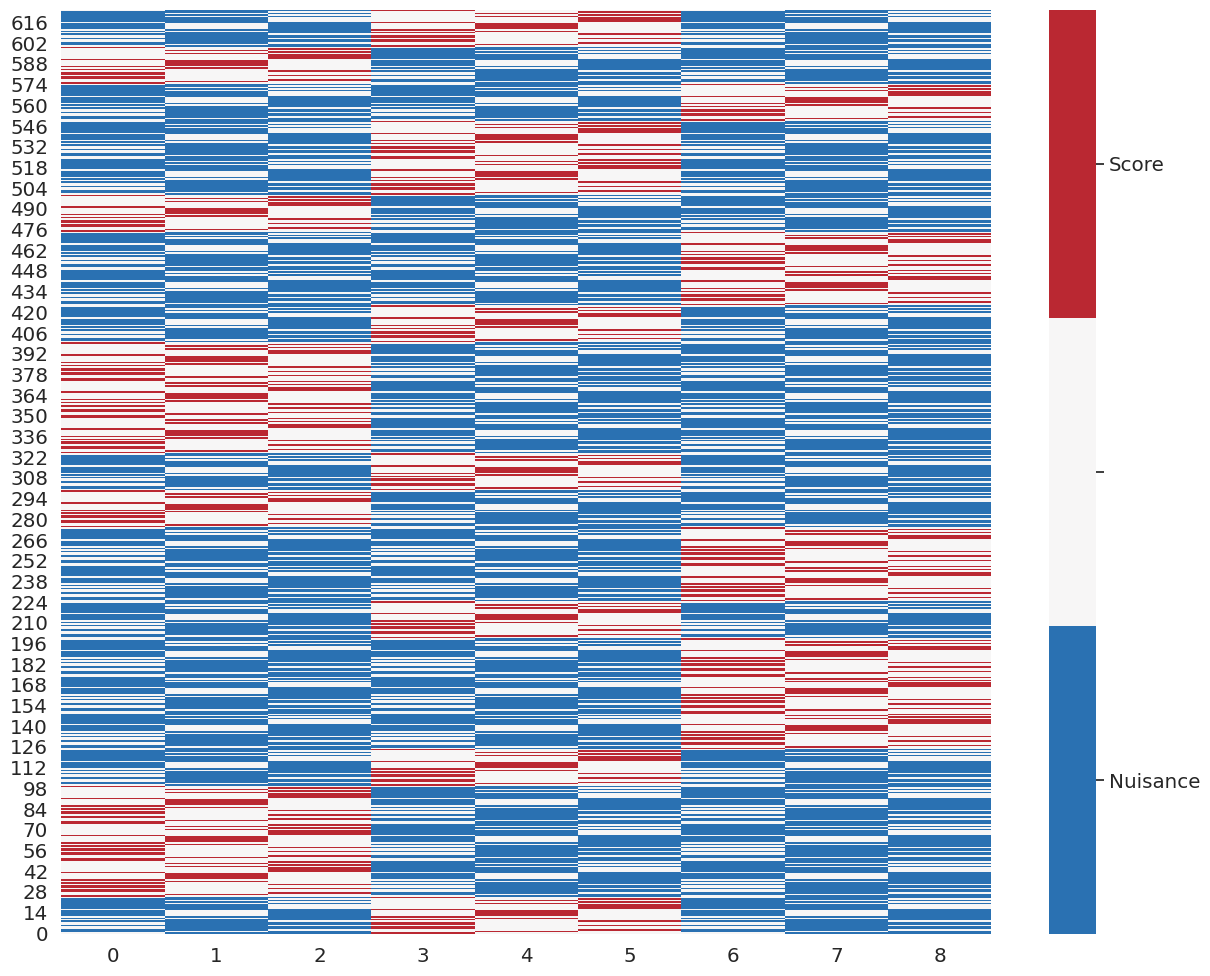

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])